In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
import numpy as np
import io
import os
import matplotlib.pyplot as plt

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

#Download dataset.
#(only a part of the train data of the original dataset have been taken in to consideration).

Data_URL = "http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip"

file_path = tf.keras.utils.get_file("twitter.zip", Data_URL, extract=True)

csv_file = os.path.join(os.path.dirname(file_path), 'training.1600000.processed.noemoticon.csv')

81371136/81363704 [==============================] - 1s 0us/step


In [ ]:
BATCH_SIZE=50
COLUMN_NAMES=['label','id','date','query','user','text'] #the names of the column are specified in the web page that contains the dataset.
LABEL_NAME='label'
COLUMN_SELECTED=['label','text']

#Only 5000 messages will be taken into consideration.
DATASET_SIZE=16000

In [ ]:
#Create the dataset.
complete_dataset=tf.data.experimental.make_csv_dataset(csv_file,1,column_names=COLUMN_NAMES,label_name=LABEL_NAME,select_columns=COLUMN_SELECTED,num_epochs=1,shuffle=True,shuffle_buffer_size=1600000,shuffle_seed=12311)

In [ ]:
# Delete commas and insert space before the rest of the puntation.
def insert_space(text):
  text=tf.strings.regex_replace(text,"([,])","")
  text=tf.strings.regex_replace(text,"([.!?();])"," \\1 ")
  text=tf.strings.regex_replace(text,"  "," ")
  text=tf.strings.regex_replace(text,"\. \. \. \.","....")
  text=tf.strings.regex_replace(text,"\. \. \.","...")
  text=tf.strings.regex_replace(text,"\. \.","..")
  #encode in UTF-8
  text=tf.strings.unicode_decode(text,input_encoding="UTF-8")
  text=tf.strings.unicode_encode(text,output_encoding="UTF-8")
  return text

# Convert label values 0-2-4 in 0-1-2:
def convert_label(label):
  return int(label/2)


#The lines of the dataset can start with ham (if they are not spam) or with spam (if they are spam).
#The label associated to spam is 1, while the one associated with ham is 0.  

def process_line(line_text,label):
    text = tf.stack(list(line_text.values()), axis=1)
    text=insert_space(text[0][0])
    converted_label=convert_label(label[0])
    return text, converted_label


In [ ]:
labeled_dataset=complete_dataset.map(process_line, num_parallel_calls=AUTOTUNE)

In [ ]:
#Take only 16000 example.
shuffled_dataset=labeled_dataset.take(DATASET_SIZE)

In [ ]:
#Create the vocabulary and store its dimension.
tokenizer=tfds.features.text.Tokenizer()

vocabulary=set()
for text,_ in shuffled_dataset:
  token=tokenizer.tokenize(text.numpy())
  vocabulary.update(token)

VOCABULARY_SIZE=len(vocabulary)

In [ ]:
#Define the encoder.
encoder=tfds.features.text.TokenTextEncoder(vocabulary)

In [ ]:
#Encode.
def encode(text, label):
  encoded_text = encoder.encode(text.numpy())
  return encoded_text, label

def encode_map_fn(text, label):
  # py_func doesn't set the shape of the returned tensors.
  encoded_text, label = tf.py_function(encode, 
                                       inp=[text, label], 
                                       Tout=(tf.int64, tf.int32))

  # `tf.data.Datasets` work best if all components have a shape set
  #  so set the shapes manually: 
  encoded_text.set_shape([None])
  label.set_shape([])

  return encoded_text, label

encoded_dataset = shuffled_dataset.map(encode_map_fn)

In [ ]:
#define the number of element in the training and in the test set.
BATCH_NUMBER=int(round(DATASET_SIZE/BATCH_SIZE))
TEST_NUMBER=int(BATCH_NUMBER/4)

# Divide the messages in the training and in the test sets.
ds_train=encoded_dataset.take((BATCH_NUMBER-TEST_NUMBER)*BATCH_SIZE)
ds_test=encoded_dataset.skip((BATCH_NUMBER-TEST_NUMBER)*BATCH_SIZE)

# The strings must be batched and padded to the length of the longest string in the batch.
ds_train=ds_train.padded_batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
ds_test=ds_test.padded_batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

In [ ]:
EMBEDDING_DIM=32

#Define the model.
model=keras.Sequential([
                        keras.layers.Embedding(VOCABULARY_SIZE+2, EMBEDDING_DIM),
                        keras.layers.Bidirectional(keras.layers.GRU(64,return_sequences=True)),
                        keras.layers.Bidirectional(keras.layers.GRU(64,return_sequences=True)),
                        keras.layers.Bidirectional(keras.layers.GRU(32)),
                        keras.layers.Dense(32, activation='relu'),
                        keras.layers.Dense(32, activation='relu'),
                        keras.layers.Dropout(0.25),
                        keras.layers.Dense(32, activation='relu'),
                        keras.layers.Dropout(0.25),
                        keras.layers.Dense(3),
])

#Compile the model.
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])   

#Train the model.
history=model.fit(ds_train,validation_data=ds_test,epochs=10)    

Epoch 1/10
240/240 [==============================] - 24s 102ms/step - loss: 0.7223 - accuracy: 0.5683 - val_loss: 0.5740 - val_accuracy: 0.6955
Epoch 2/10
240/240 [==============================] - 23s 96ms/step - loss: 0.5577 - accuracy: 0.7287 - val_loss: 0.5180 - val_accuracy: 0.7460
Epoch 3/10
240/240 [==============================] - 20s 84ms/step - loss: 0.5233 - accuracy: 0.7451 - val_loss: 0.4862 - val_accuracy: 0.7742
Epoch 4/10
240/240 [==============================] - 20s 83ms/step - loss: 0.5012 - accuracy: 0.7642 - val_loss: 0.4944 - val_accuracy: 0.7742
Epoch 5/10
240/240 [==============================] - 20s 84ms/step - loss: 0.4813 - accuracy: 0.7795 - val_loss: 0.4549 - val_accuracy: 0.7830
Epoch 6/10
240/240 [==============================] - 20s 85ms/step - loss: 0.4782 - accuracy: 0.7803 - val_loss: 0.4649 - val_accuracy: 0.7855
Epoch 7/10
240/240 [==============================] - 20s 85ms/step - loss: 0.4794 - accuracy: 0.7792 - val_loss: 0.4499 - val_accuracy

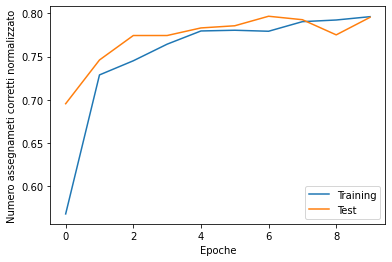

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'], '')
plt.xlabel("Epoche")
plt.ylabel('Numero assegnameti corretti normalizzato')
plt.legend(['Training', 'Test'])
plt.show()

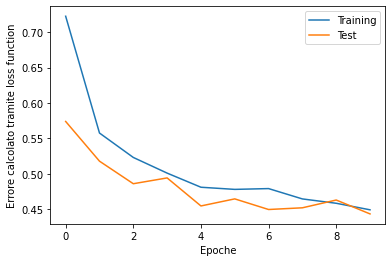

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], '')
plt.xlabel("Epoche")
plt.ylabel('Errore calcolato tramite loss function')
plt.legend(['Training', 'Test'])
plt.show()